In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
os.listdir('/training/tracking-nuclear')

['val.trks',
 'inputs.yaml',
 'metadata.yaml',
 'train.trks',
 '.gitignore',
 'params.yaml',
 'dvc.yaml',
 'dvc.lock',
 'data-source.npz',
 'test.trks']

In [3]:
%%time
path_temp_trks = '/training/tracking-nuclear/test.trks'
all_data = [load_trks(path_temp_trks)]

CPU times: user 15 s, sys: 1.73 s, total: 16.8 s
Wall time: 16.8 s


In [4]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

100%|███████████████████████████████████████████| 12/12 [00:54<00:00,  4.53s/it]
2022-06-29 05:02:12.929120: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-29 05:02:13.507973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


CPU times: user 7min 25s, sys: 9min 26s, total: 16min 52s
Wall time: 1min 55s


In [5]:
%%time
track_info = concat_tracks(all_tracks)

CPU times: user 365 ms, sys: 473 ms, total: 837 ms
Wall time: 835 ms


In [6]:
for k, v in track_info.items():
    print(k, v.shape)

appearances (12, 71, 331, 32, 32, 1)
centroids (12, 71, 331, 2)
morphologies (12, 71, 331, 3)
adj_matrices (12, 71, 331, 331)
norm_adj_matrices (12, 71, 331, 331)
temporal_adj_matrices (12, 70, 331, 331, 3)


In [7]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

def prepare_dataset(track_info, batch_size=1, buffer_size=256,
                    seed=None, val_split=0.2):
    
    # Merge tracks along the batch axis
    appearances = track_info['appearances']
    
    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])
    
    # Normalize appearances
    appearances = norm(appearances)
    
    input_dict = {'appearances': appearances}
    
    output_dict = {'appearances_decoder': appearances}
    
    dataset = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)
    
    # batch the data
    data = dataset.repeat().batch(batch_size)
    
    # prefetch the data
    data = dataset.prefetch(tf.data.AUTOTUNE)
    
    return data

In [8]:
# downloaded the validation dataset (val.trks)
val_data = prepare_dataset(track_info, batch_size=1)

2022-06-29 05:32:22.473220: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2310242304 exceeds 10% of free system memory.
2022-06-29 05:32:24.160307: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2310242304 exceeds 10% of free system memory.
2022-06-29 05:32:25.827838: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2310242304 exceeds 10% of free system memory.
2022-06-29 05:32:27.032520: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2310242304 exceeds 10% of free system memory.


In [10]:
it = iter(val_data)

2022-06-29 05:35:58.919014: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2310242304 exceeds 10% of free system memory.


2022-06-29 05:36:34.914668: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: slice index 32 of dimension 1 out of bounds.


InvalidArgumentError: slice index 32 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

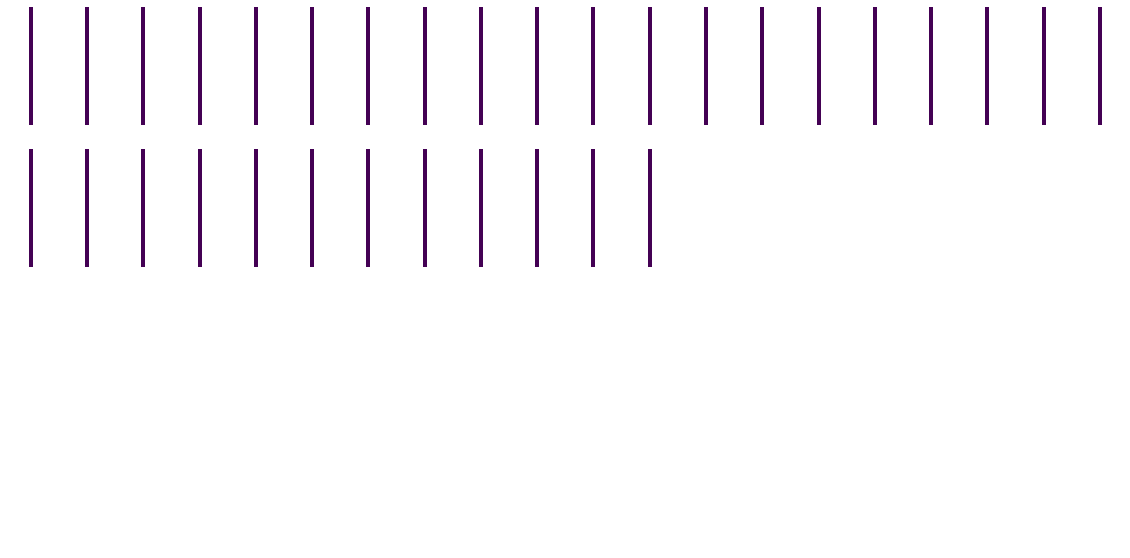

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,20,figsize=(20,10))
for ax in axes.flatten():
    ax.set_axis_off()

nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][0,j])
    axes.flatten()[j].set_axis_off()

In [13]:
print(len(nxt))
print(nxt[0].keys())
print(nxt[1].keys())
print(type(nxt[0]['appearances']))
print(nxt[0]['appearances'].get_shape())

2
dict_keys(['appearances'])
dict_keys(['appearances_decoder'])
<class 'tensorflow.python.framework.ops.EagerTensor'>
(71, 32, 32, 1)


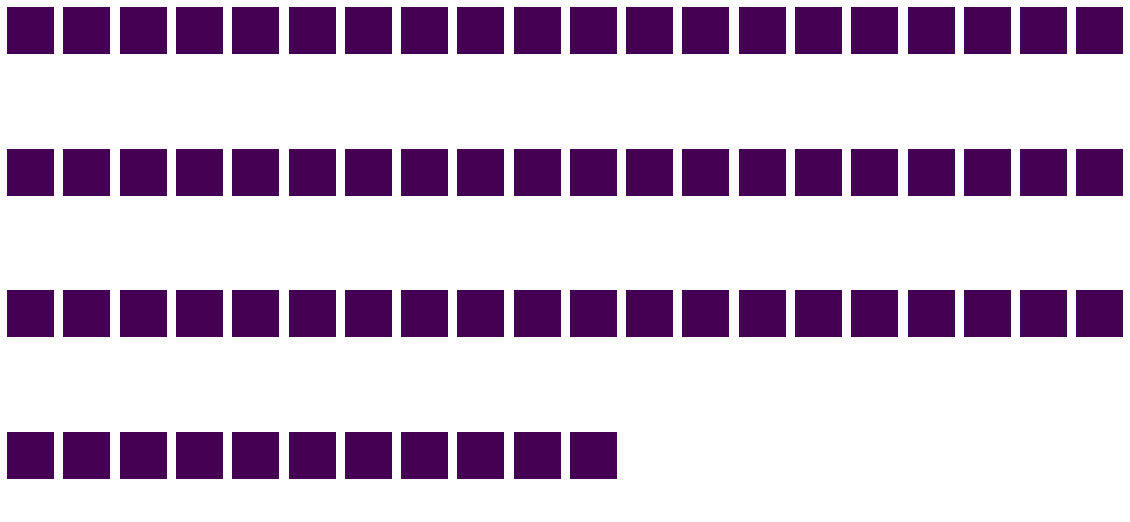

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,20,figsize=(20,10))
for ax in axes.flatten():
    ax.set_axis_off()

nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][j])
    axes.flatten()[j].set_axis_off()

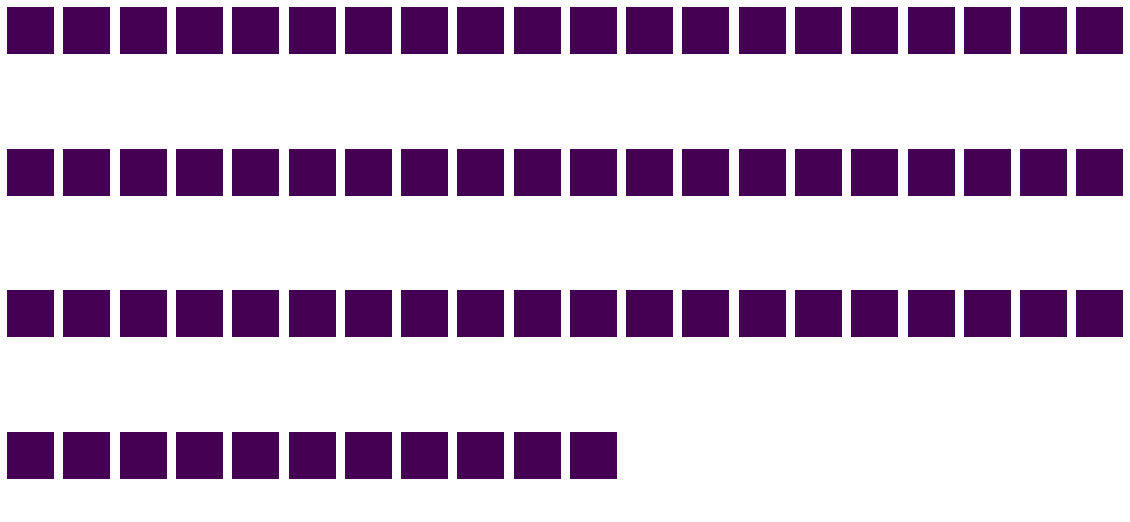

In [53]:
fig, axes = plt.subplots(4,20,figsize=(20,10))
for ax in axes.flatten():
    ax.set_axis_off()

nxt = it.next()
for j in range(71):
    axes.flatten()[j].imshow(nxt[0]['appearances'][j])
    axes.flatten()[j].set_axis_off()